In [1]:
% matplotlib inline
from __future__ import print_function, division
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,recall_score,classification_report 

In [2]:
def read_file(path):
    t0 = time.time()
    df = pd.read_csv(path, na_values=['null', 'Na'])
    print("%.2f secs ==> pd.read_csv"%(time.time()-t0))
    df['useragent_1'] = df['useragent'].apply(lambda x: x.split('_')[0])
    df['useragent_2'] = df['useragent'].apply(lambda x: x.split('_')[1])
    return df

In [3]:
df_train = read_file('./data/train.csv')
df_val = read_file('./data/validation.csv')
df_test = read_file('./data/test.csv')

34.12 secs ==> pd.read_csv
2.19 secs ==> pd.read_csv
3.05 secs ==> pd.read_csv


## Feature Engineering

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, mean_squared_error

In [5]:
col_names=df_train.columns.tolist()
print(col_names)

['click', 'weekday', 'hour', 'bidid', 'userid', 'useragent', 'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag', 'useragent_1', 'useragent_2']


In [6]:
print (df_train.describe())

              click       weekday          hour        region          city  \
count  2.430981e+06  2.430981e+06  2.430981e+06  2.430981e+06  2.430981e+06   
mean   7.375623e-04  2.888556e+00  1.348925e+01  1.493833e+02  1.543295e+02   
std    2.714809e-02  2.055223e+00  6.567105e+00  1.020631e+02  1.033093e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  1.000000e+00  1.000000e+01  7.900000e+01  7.900000e+01   
50%    0.000000e+00  3.000000e+00  1.400000e+01  1.460000e+02  1.520000e+02   
75%    0.000000e+00  5.000000e+00  1.900000e+01  2.160000e+02  2.220000e+02   
max    1.000000e+00  6.000000e+00  2.300000e+01  3.950000e+02  3.990000e+02   

         adexchange  urlid     slotwidth    slotheight    slotformat  \
count  2.381152e+06    0.0  2.430981e+06  2.430981e+06  1.925991e+06   
mean   2.109685e+00    NaN  5.774218e+02  1.885723e+02  3.335576e-01   
std    8.764370e-01    NaN  3.216738e+02  1.314946e+02  5.887512e-01   


In [7]:
def bid_price(bidprice):
    if bidprice <= 241:
        return 0
    if 241< bidprice <= 294:
        return 1
    if 294 < bidprice <= 300:
        return 2
    if 300 < bidpreice :
        return 3

In [8]:
def pay_price(payprice):
    if payprice <= 33:
        return 0
    if 33< payprice <= 68:
        return 1
    if 68 < payprice <= 99:
        return 2
    if 99 < payprice :
        return 3

In [9]:
def hour_fn(hour):
    if hour <= 10:
        return 0
    if 10 < hour <= 14:
        return 1
    if 14 < hour <= 19:
        return 2
    if 19< hour <= 24:
        return 3

In [10]:
def slot_width_fn(width):
    if width <= 300:
        return 0
    if 300 < width <= 250:
        return 1
    if width > 250:
        return 2

In [11]:
def slot_height_fn(height):
    if height <= 90:
        return 0
    if 90 < height <= 240:
        return 1
    if height > 240:
        return 2

In [12]:
def city_fn(city):
    if city <= 93:
        return 0
    if 93 < city <= 187:
        return 1
    if 187 < city <= 303:
        return 2
    if city > 303:
        return 3

In [13]:
def region_fn(region):
    if region <= 65:
        return 0
    if 65 < region <= 183:
        return 1
    if 183 < region <= 325:
        return 2
    if region > 325:
        return 3

In [14]:
def slot_price_fn(price):
    if price <= 50:
        return 0
    if 50 < price <= 98:
        return 1
    if price > 98:
        return 2

In [15]:
def to_index(df, feature):
    return LabelEncoder().fit_transform(df[feature].values)

def to_one_hot(df, features):
    return OneHotEncoder().fit_transform(df[features].values).toarray()
    

In [16]:
def preprocess(df):
    df['hour'] = df['hour'].apply(hour_fn)
    df['slotwidth'] = df['slotwidth'].apply(slot_width_fn)
    df['slotheight'] = df['slotheight'].apply(slot_height_fn)
    df['city'] = df['city'].apply(city_fn)
    df['region'] = df['region'].apply(region_fn)
    df['slotvisibility'] = df['slotvisibility'].apply(lambda x: str(x))
    df['slotformat'] = df['slotformat'].apply(lambda x: str(x))
    df['adexchange'] = df['adexchange'].apply(lambda x: str(x))
    df['slotprice'] = df['slotprice'].apply(slot_price_fn)
    
    for feat in ['useragent_1', 'useragent_2', 'advertiser', 'slotvisibility', 'slotformat', 'adexchange']:
        df[feat] = to_index(df, feat)
    
    one_hot = to_one_hot(df,
        ['weekday', 'hour', 'useragent_1', 'useragent_2', 'city', 'region', 'adexchange',
         'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
         'advertiser',])
    
    return one_hot

### Down Sampling

In [17]:

pos_len = 100*len(df_train[df_train['click']==1])
pos_indices = np.array(df_train[df_train['click']==1].index)

# Picking the indices of the normal classes
neg_indices = df_train[df_train['click']==0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(neg_indices, pos_len, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([pos_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df_train.iloc[under_sample_indices,:]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'click']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'click']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.click == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.click == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Percentage of normal transactions:  0.9900990099009901
Percentage of fraud transactions:  0.009900990099009901
Total number of transactions in resampled data:  181093


### LGBM

In [18]:
from lightgbm import LGBMClassifier
from sklearn.cross_validation import KFold

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
def simulation(df, bid_vals, base_bid):
    budget = 6250
    paid = 0
    clicks = 0
    for idx, row in df.iterrows():
        if paid > budget:
            break
        
        if bid_vals[idx] >= row['payprice']:
            if row['click'] == 1:
                clicks += 1
            paid += (row['payprice'] / 1000)
    imps = idx + 1
    ctr = clicks / imps * 100
    cpm = ((paid / imps) * 1000)
    cpc = paid / clicks
    return clicks, ctr, paid, cpm, cpc, idx, len(df)

In [20]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
def plot_roc(y_val, y_val_proba):
    fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
    f, axes = plt.subplots(1, figsize=(8, 5))
    lab = 'AUC=%.5f' % auc(fpr, tpr)
    axes.step(fpr, tpr, lw=2,label=lab)
    axes.legend(loc='lower right', fontsize='small')
    plt.show()

(181093, 71) (303925, 71)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


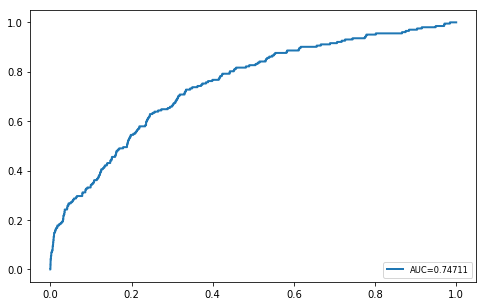

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    303723
          1       0.03      0.00      0.01       202

avg / total       1.00      1.00      1.00    303925



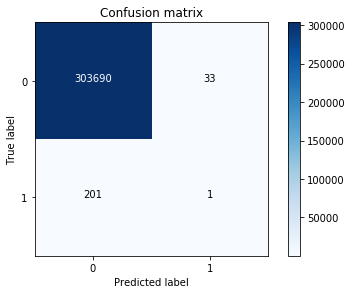

cross entropy loss:  0.012572029870096564


In [22]:
import itertools
from sklearn.metrics import log_loss
ratio = 100
pos_df = df_train[df_train['click']==1]
neg_df = df_train[df_train['click']==0]
reduced_neg_df = neg_df.sample(ratio*len(pos_df), random_state=100)
down_sample_df = pd.concat([pos_df]+[reduced_neg_df], ignore_index=True)

X_train = preprocess(down_sample_df.copy())
y_train = down_sample_df['click'].values

X_val = preprocess(df_val.copy())
y_val = df_val['click'].values

print(X_train.shape, X_val.shape)

lg = LGBMClassifier()
lg.fit(X_train, y_train)
y_val_pred = lg.predict(X_val)
y_val_proba = lg.predict_proba(X_val)[:, 1]
plot_roc(y_val, y_val_proba)
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_val_pred)
np.set_printoptions(precision=2)

#print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print("cross entropy loss: ",log_loss(y_val,y_val_proba))

In [23]:
avgCTR = df_train['click'].values.mean()
base_bid = 5.5
pCTRs = y_val_proba
bid_vals = pCTRs * base_bid / avgCTR
print(bid_vals)

clicks, ctr, paid, cpm, cpc, idx, total_rows = simulation(df_val, bid_vals, base_bid)
print("Linear Bidding | Clicks: %d | CTR: %.3f | Spent: %d | Paid: %d | CPM: %.2f | CPC: %.2f | Impressions: %d" % (
    clicks, ctr, paid, paid, cpm, cpc, idx))

[ 40.12  39.91  37.99 ... 116.97  61.72  33.37]
Linear Bidding | Clicks: 123 | CTR: 0.040 | Spent: 6033 | Paid: 6033 | CPM: 19.85 | CPC: 49.05 | Impressions: 303924


### Oversample

In [36]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

df_train=df_train[df_train.payprice>=df_train.slotprice]
df_val=df_val[df_val.payprice>=df_val.slotprice]

pos_df = df_train[df_train['click']==1]
neg_df = df_train[df_train['click']==0]


features=df_train.copy()
labels=df_train['click']
features_train=preprocess(features)


X_val = preprocess(df_val.copy())
print(X_val.shape)
y_val = df_val['click'].values


oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_sample(features_train,labels)

(302408, 71)


In [25]:
len(os_labels[os_labels==1])
os_features.shape

(4833584, 71)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


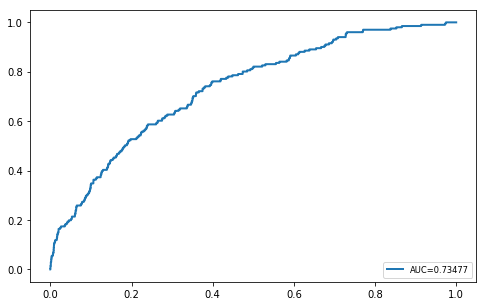

             precision    recall  f1-score   support

          0       1.00      0.98      0.99    302207
          1       0.01      0.13      0.01       201

avg / total       1.00      0.98      0.99    302408



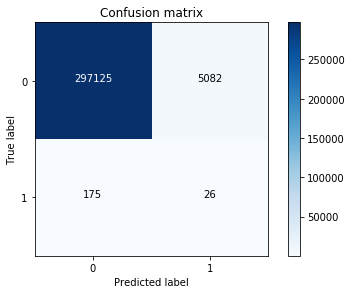

cross entropy loss:  0.08672731350860224


In [26]:
import itertools
lg = LGBMClassifier()
lg.fit(os_features, os_labels)
y_val_pred = lg.predict(X_val)
y_val_proba = lg.predict_proba(X_val)[:, 1]
plot_roc(y_val, y_val_proba)
print(classification_report(y_val, y_val_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_val_pred)
np.set_printoptions(precision=2)

#print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print("cross entropy loss: ",log_loss(y_val,y_val_proba))

In [27]:
avgCTR = df_train['click'].values.mean()
base_bid = 5.5
pCTRs = y_val_proba
bid_vals = pCTRs * base_bid / avgCTR
print(bid_vals)

clicks, ctr, paid, cpm, cpc, idx, total_rows = simulation(df_val, bid_vals, base_bid)
print("Linear Bidding | Clicks: %d | CTR: %.3f | Spent: %d | Paid: %d | CPM: %.2f | CPC: %.2f | Impressions: %d" % (
    clicks, ctr, paid, paid, cpm, cpc, idx))

[137.59  70.7  234.   ... 599.5  148.26 247.82]
Linear Bidding | Clicks: 54 | CTR: 0.053 | Spent: 6250 | Paid: 6250 | CPM: 61.84 | CPC: 115.74 | Impressions: 101075


In [8]:
"""
from sklearn.ensemble import GradientBoostingClassifier

clf2 = GradientBoostingClassifier()
clf2.fit(X_train, y_train)
y_val_pred = clf2.predict(X_val)
y_val_proba = clf2.predict_proba(X_val)[:, 1]

base_bid = 5.5
pCTRs = y_val_proba
bid_vals = pCTRs * base_bid / avgCTR
print(bid_vals)

clicks, paid, idx, total_rows = simulation(df_val, bid_vals, base_bid)
print("Linear Bidding | Clicks: %d | Paid: %d | Rows: %d / %d" % (clicks, paid, idx, total_rows))

X_test = preprocess(df_test.copy())
pCTRs = clf.predict_proba(X_test)[:, 1]
bid_vals = pCTRs * base_bid / avgCTR
df_submit = pd.read_csv('./data/Group_7.csv')
df_submit['bidprice'] = bid_vals
df_submit.to_csv('./testing_bidding_price.csv', index=False)
"""

'\nfrom sklearn.ensemble import GradientBoostingClassifier\n\nclf2 = GradientBoostingClassifier()\nclf2.fit(X_train, y_train)\ny_val_pred = clf2.predict(X_val)\ny_val_proba = clf2.predict_proba(X_val)[:, 1]\n\nbase_bid = 5.5\npCTRs = y_val_proba\nbid_vals = pCTRs * base_bid / avgCTR\nprint(bid_vals)\n\nclicks, paid, idx, total_rows = simulation(df_val, bid_vals, base_bid)\nprint("Linear Bidding | Clicks: %d | Paid: %d | Rows: %d / %d" % (clicks, paid, idx, total_rows))\n\nX_test = preprocess(df_test.copy())\npCTRs = clf.predict_proba(X_test)[:, 1]\nbid_vals = pCTRs * base_bid / avgCTR\ndf_submit = pd.read_csv(\'./data/Group_7.csv\')\ndf_submit[\'bidprice\'] = bid_vals\ndf_submit.to_csv(\'./testing_bidding_price.csv\', index=False)\n'